In [243]:
import os
import json
import glob
from matplotlib import pyplot as plt
from ocpmodels.trainers import ForcesTrainer

In [331]:
root_dir = "/private/home/mshuaibi/baselines"
exp_log = ["dimenet_20Mv3"]

In [332]:
exps = []
for e in exp_log:
    exp_path = os.path.join(root_dir, f"logs/{e}/exp")
    with open(os.path.join(exp_path, os.listdir(exp_path)[0]), "r") as f:
        exps += f.read().splitlines()

for i in range(len(exps)):
    exps[i] = json.loads(exps[i])

In [338]:
iters = 1
eval_every=-1000

In [340]:
iters % (-1*eval_every)

1

In [333]:
def read_ocp_log(slurm_job_id):
    try:
        log_path = glob.glob(root_dir + "/logs/dimenet_20Mv3/{}/*.out".format(slurm_job_id))[0]
    except:
        return [], []
    log = open(log_path, "r").read().splitlines()
    train, val = [], []
    model_sizes = []
    is_next_val = False
    for l in log:
        fragments = l.split(",")
        if "ERROR" in fragments[0]:
            return train, val
        # train.
        elif fragments[0].endswith("parameters."):
            size = int(fragments[0].split(" ")[-2])
            model_sizes.append(size)
        elif is_next_val is False and fragments[0].startswith("epoch"):
            metrics = {}
            for f in fragments:
                sub = f.split(":")
                metrics[sub[0].strip()] = float(sub[1].strip())
            train.append(metrics)
        # val.
        elif is_next_val is True:
            epoch = round(metrics["epoch"])
            metrics = {}
            try:
                for f in fragments:
                    sub = f.split(":")
                    metrics[sub[0].strip()] = float(sub[1].strip())
            except:
                print(slurm_job_id)
            metrics["epoch"] = epoch
            val.append(metrics)
            is_next_val = False
        if l == "### Evaluating on val.":
            is_next_val = True
    return train, val, model_sizes

In [334]:
logs = [read_ocp_log(e["slurm_id"]) for e in exps]

UnboundLocalError: local variable 'metrics' referenced before assignment

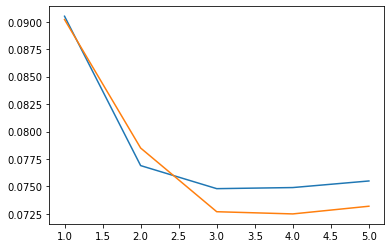

In [335]:
for i in range(len(logs)):
    try:
        plt.plot([e["epoch"] for e in logs[i][1]],
                 [e["force_z/mae"] for e in logs[i][1]],
                 label=exps[i]["config"]["identifier"])
    except:
        continue

In [336]:
metric = "force_z/mae"

In [337]:
best_val_maes = []
for i in range(len(logs)):
    try:
        best_val_maes.append((i, min([m[metric] for m in logs[i][1]])))
    except:
        continue
print("Jobs completed:", len(best_val_maes))
best_val_maes_sorted = sorted(best_val_maes, key=lambda x: x[1])[::-1]
configs_sorted = [(i[1], exps[i[0]]) for i in best_val_maes_sorted][::-1]
model_sizes_sorted = []
for i in best_val_maes_sorted[::-1]:
    try:
        model_sizes_sorted.append(logs[i[0]][2])
    except:
        model_sizes_sorted.append("N/A")

for i in range(len(best_val_maes)):
    print(configs_sorted[i][0],
          configs_sorted[i][1]["slurm_id"],
          configs_sorted[i][1]["config"]["identifier"],
          model_sizes_sorted[i][0])

Jobs completed: 3
0.0725 29897494_1 dimenet_20Mv3_run1 N
0.0748 29897494_0 dimenet_20Mv3_run0 N
0.0868 29897494_2 dimenet_20Mv3_run2 N
